Training Model...
Epoch 0, Loss: 42.5402
Epoch 50, Loss: 40.7682
Epoch 100, Loss: 38.6058
Epoch 150, Loss: 35.7836
Epoch 200, Loss: 32.1597
Epoch 250, Loss: 27.6706
Epoch 300, Loss: 22.6670
Epoch 350, Loss: 18.4861
Epoch 400, Loss: 14.8313
Epoch 450, Loss: 12.2788
Epoch 500, Loss: 10.8269
Epoch 550, Loss: 10.2107
Epoch 600, Loss: 9.7785
Epoch 650, Loss: 9.7226
Epoch 700, Loss: 9.2568
Epoch 750, Loss: 8.9789
Epoch 800, Loss: 8.9490
Epoch 850, Loss: 8.6705
Epoch 900, Loss: 9.0428
Epoch 950, Loss: 8.6491

Final Test MAE: 9.3090
Final Test MSE: 543.9101
R² Score: 0.7027
Root MSE: 23.3219
Mean Absolute Percentage Accuracy: 82.95%

Neural Network R²: 0.7027, MAE: 9.31, Accuracy: 82.95%


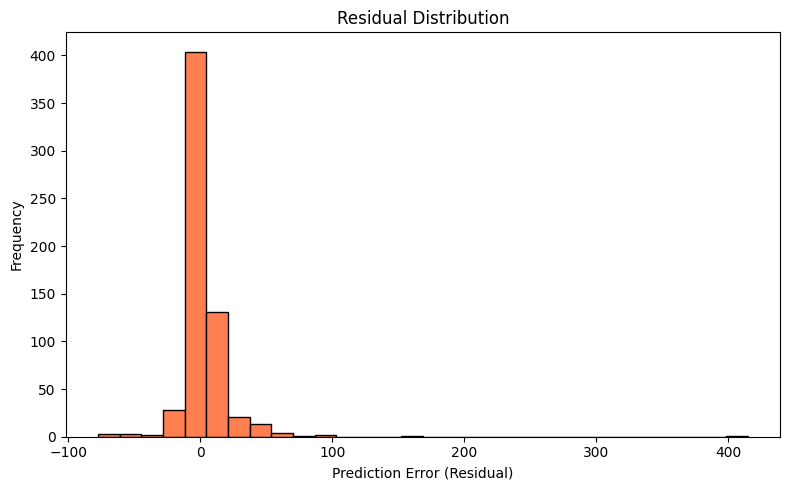

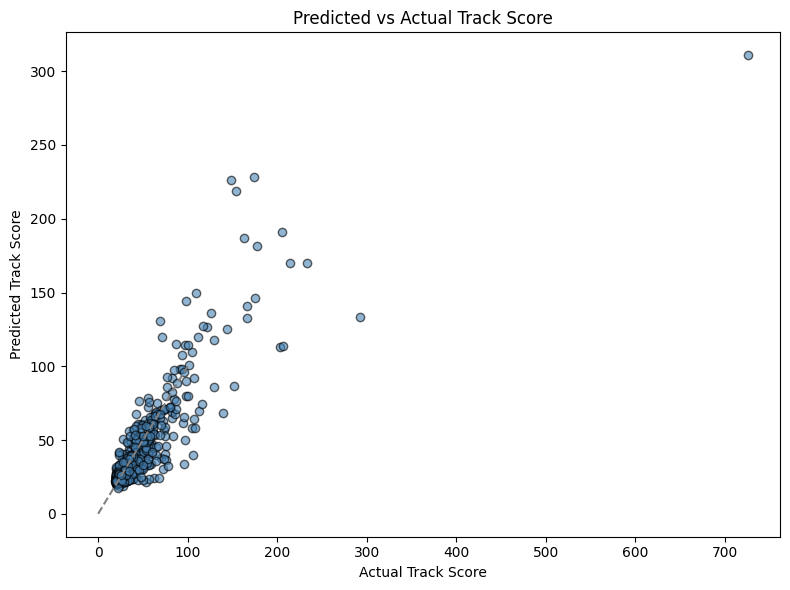

Exported predictions to 'track_score_predictions.csv'


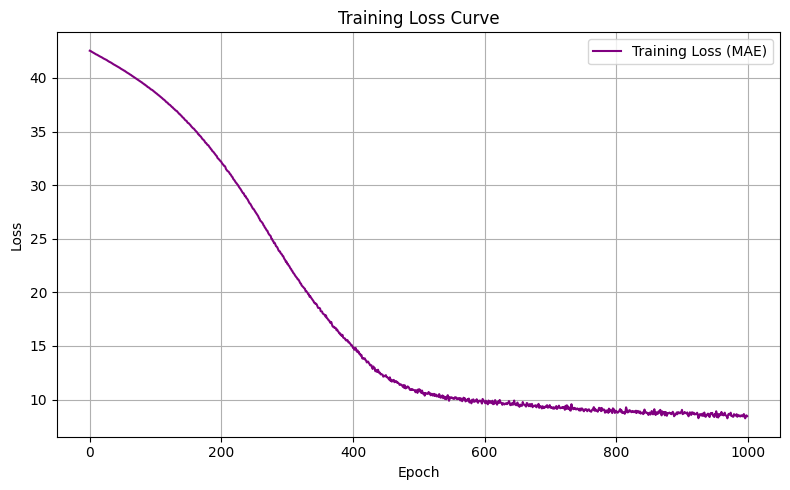

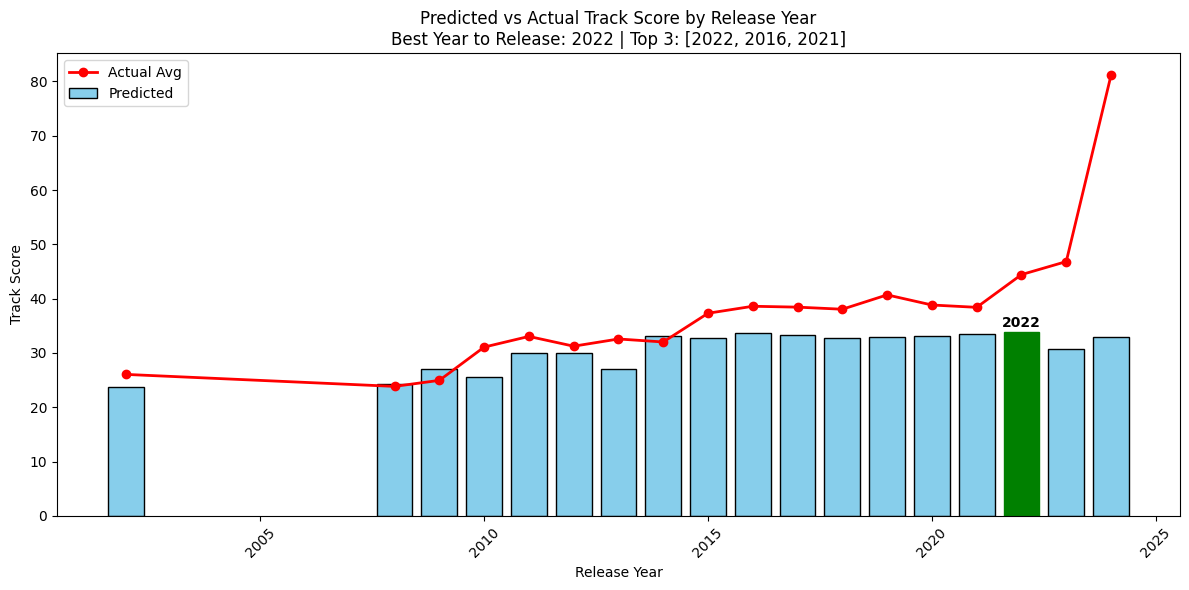

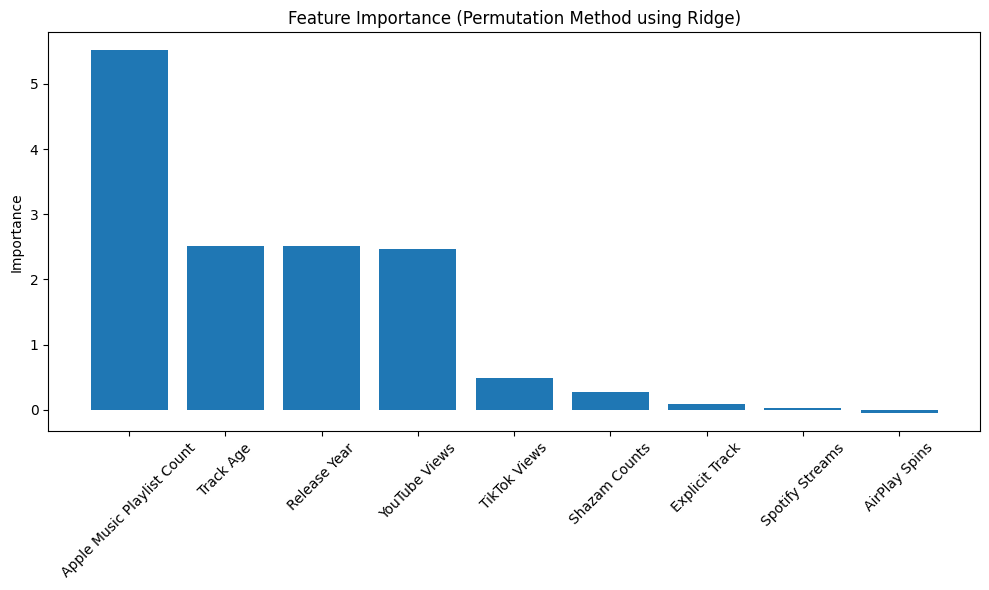


=== Classification Report for FNN ===
              precision    recall  f1-score   support

        High      0.844     0.743     0.790       109
         Low      0.768     0.896     0.827       280
      Medium      0.712     0.604     0.654       225

    accuracy                          0.762       614
   macro avg      0.774     0.748     0.757       614
weighted avg      0.761     0.762     0.757       614

Class distribution (actual): Counter({'Low': 280, 'Medium': 225, 'High': 109})
Class distribution (predicted): Counter({'Low': 327, 'Medium': 191, 'High': 96})


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load Dataset
csv_path = "Spotify_Data.csv"
df = pd.read_csv(csv_path, encoding='latin1')

# ============================
# Data Cleaning & Feature Engineering
# ============================
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year

# Clean numeric columns before feature engineering
# df['Spotify Playlist Count'] = df['Spotify Playlist Count'].astype(str).str.replace(',', '', regex=False)
# df['Spotify Playlist Reach'] = df['Spotify Playlist Reach'].astype(str).str.replace(',', '', regex=False)
df['Spotify Streams'] = df['Spotify Streams'].astype(str).str.replace(',', '', regex=False)

# Convert to numeric
for col in ['Spotify Streams']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Derived Features
df['Track Age'] = 2025 - df['Release Year']
# df['Playlist Count x Reach'] = df['Spotify Playlist Count'] * df['Spotify Playlist Reach']
# df['Streams per Playlist'] = df['Spotify Streams'] / (df['Spotify Playlist Count'] + 1)

# Base + Engineered Feature Columns
feature_cols = [
    'Release Year', 'Track Age', 'Explicit Track',
    'Spotify Streams', 'YouTube Views', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'Shazam Counts'
]

# Add target
df['Track Score'] = pd.to_numeric(df['Track Score'], errors='coerce')

# Clean and convert all relevant columns to numeric
for col in feature_cols:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Log-transform skewed features
skewed_cols = [
    'Spotify Streams', 'YouTube Views', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'Shazam Counts'
]
for col in skewed_cols:
    df[col] = np.log1p(df[col])

# Drop NA
df = df.dropna(subset=['Track Score'] + feature_cols)

# Filter out years with too little data
year_counts = df['Release Year'].value_counts()
df = df[df['Release Year'].isin(year_counts[year_counts >= 5].index)]

# ==========================
# Feature Preparation
# ==========================
X = df[feature_cols].fillna(0)
y = df['Track Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# ==========================
# Define Neural Network
# ==========================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return self.fc3(x)

model = Net()
criterion = nn.L1Loss()  # Switch to MAE for better real-world accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ==========================
# Training
# ==========================
print("Training Model...")
losses = []  # Initialize list to track training loss
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # Track each epoch's loss
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ==========================
# Evaluation
# ==========================
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mae = criterion(predictions, y_test)
    y_true = y_test.numpy().flatten()
    y_pred = predictions.numpy().flatten()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"\nFinal Test MAE: {mae.item():.4f}")
    print(f"Final Test MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Root MSE: {rmse:.4f}")
    print(f"Mean Absolute Percentage Accuracy: {accuracy:.2f}%")
    print(f"\nNeural Network R²: {r2:.4f}, MAE: {mae:.2f}, Accuracy: {accuracy:.2f}%")
    

    # Residual plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=30, edgecolor='black', color='coral')
    plt.title('Residual Distribution')
    plt.xlabel('Prediction Error (Residual)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Scatter: predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='steelblue', edgecolor='k')
    plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
    plt.xlabel('Actual Track Score')
    plt.ylabel('Predicted Track Score')
    plt.title('Predicted vs Actual Track Score')
    plt.tight_layout()
    plt.show()

    # Export predictions
    results_df = pd.DataFrame({
        'Actual Track Score': y_true,
        'Predicted Track Score': y_pred
    })
    results_df.to_csv('track_score_predictions.csv', index=False)
    print("Exported predictions to 'track_score_predictions.csv'")

    # ==========================
    # Loss Curve
    # ==========================
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss (MAE)', color='purple')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==========================
    # Predicted vs Actual by Release Year
    # ==========================
    grouped = df.groupby('Release Year')
    mean_features = grouped[feature_cols].mean()
    mean_features = mean_features.copy()
    mean_features['Release Year'] = mean_features.index
    yearly_means = mean_features.reset_index(drop=True)

    years = yearly_means['Release Year'].tolist()
    predicted_scores = []

    for _, row in yearly_means.iterrows():
        features = [row[col] for col in feature_cols]
        scaled = scaler.transform(pd.DataFrame([features], columns=feature_cols))
        tensor_input = torch.tensor(scaled, dtype=torch.float32)
        with torch.no_grad():
            pred = model(tensor_input).item()
        predicted_scores.append(pred)

    actual_scores = df.groupby('Release Year')['Track Score'].mean().reindex(years).values
    best_year = years[np.argmax(predicted_scores)]
    top_3_years = [years[i] for i in np.argsort(predicted_scores)[-3:][::-1]]

    colors = ['orange' if year == best_year else 'skyblue' for year in years]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(years, predicted_scores, color=colors, edgecolor='black', label='Predicted')
    plt.plot(years, actual_scores, color='red', marker='o', linewidth=2, label='Actual Avg')

    # Annotate best year
    best_index = years.index(best_year)
    bars[best_index].set_color('green')
    plt.text(years[best_index], predicted_scores[best_index] + 1,
             f"{best_year}", ha='center', color='black', fontweight='bold')

    plt.title(f'Predicted vs Actual Track Score by Release Year\nBest Year to Release: {best_year} | Top 3: {top_3_years}')
    plt.xlabel('Release Year')
    plt.ylabel('Track Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

     # ==========================
    # Feature Importance via Permutation
    # ==========================
    from sklearn.inspection import permutation_importance
    from sklearn.linear_model import Ridge

    # Fit a surrogate model on the same data
    ridge = Ridge()
    ridge.fit(X_scaled, y)

    result = permutation_importance(
        ridge,
        X_scaled,
        y,
        scoring='neg_mean_absolute_error',
        n_repeats=10,
        random_state=42
    )

    importances = result.importances_mean
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_cols)), importances[sorted_idx], align='center')
    plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in sorted_idx], rotation=45)
    plt.title('Feature Importance (Permutation Method using Ridge)')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

  
from sklearn.metrics import classification_report

# === Step 1: Define a categorization function for Track Scores ===
def categorize(score):
    if score < 30:
        return 'Low'
    elif score < 60:
        return 'Medium'
    else:
        return 'High'

# === Step 2: Apply categorization to actual and predicted scores ===
y_true_class = [categorize(score) for score in y_true]
y_pred_class = [categorize(score) for score in y_pred]

# === Step 3: Generate the classification report ===
print("\n=== Classification Report for FNN ===")
print(classification_report(y_true_class, y_pred_class, digits=3))

from collections import Counter

print("Class distribution (actual):", Counter(y_true_class))
print("Class distribution (predicted):", Counter(y_pred_class))




XGBoost R²: 0.9569, MAE: 5.69, Accuracy: 85.06%


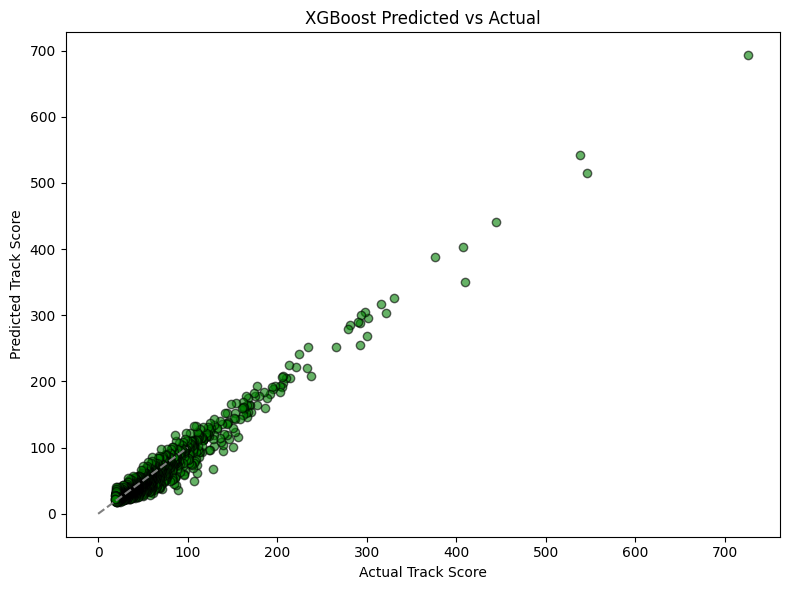


XGBoost Classification Report:
              precision    recall  f1-score   support

        High       0.90      0.82      0.86       470
         Low       0.87      0.78      0.82      1478
      Medium       0.69      0.81      0.74      1118

    accuracy                           0.80      3066
   macro avg       0.82      0.80      0.81      3066
weighted avg       0.81      0.80      0.80      3066



In [18]:
# ==========================
# Alternative Model: XGBoost
# ==========================
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor(random_state=42)
xgb_params = {
'n_estimators': [100, 300],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [3, 5, 7]
}
xgb_search = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='r2', n_jobs=-1)
xgb_search.fit(X_scaled, y)
xgb_best = xgb_search.best_estimator_
xgb_preds = xgb_best.predict(X_scaled)

xgb_r2 = r2_score(y, xgb_preds)
xgb_mae = np.mean(np.abs(y - xgb_preds))
xgb_accuracy = 100 - np.mean(np.abs((y - xgb_preds) / y) * 100)
print(f"\nXGBoost R²: {xgb_r2:.4f}, MAE: {xgb_mae:.2f}, Accuracy: {xgb_accuracy:.2f}%")

plt.figure(figsize=(8, 6))
plt.scatter(y, xgb_preds, alpha=0.6, color='green', edgecolor='k')
plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
plt.title('XGBoost Predicted vs Actual')
plt.xlabel('Actual Track Score')
plt.ylabel('Predicted Track Score')
plt.tight_layout()
plt.show()

# Define bins and labels
bins = [0, 30, 60, 750]
labels = ['Low', 'Medium', 'High']

# Convert to class labels (as strings)
y_true_class = pd.cut(y, bins=bins, labels=labels).astype(str)
y_pred_class = pd.cut(xgb_preds, bins=bins, labels=labels).astype(str)

# Generate classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_true_class, y_pred_class))


Random Forest R²: 0.9501, MAE: 5.52, Accuracy: 85.66%


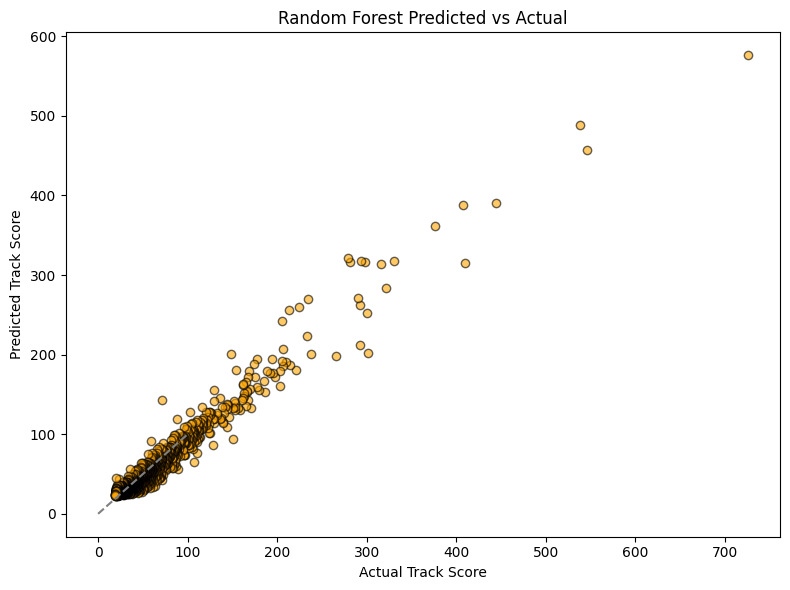


Random Forest Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.86      0.89       470
         Low       0.88      0.83      0.86      1478
      Medium       0.75      0.82      0.78      1118

    accuracy                           0.83      3066
   macro avg       0.85      0.84      0.84      3066
weighted avg       0.84      0.83      0.83      3066



In [19]:
from sklearn.metrics import classification_report

# ==========================
# Alternative Model: Random Forest
# ==========================
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)
rf_model.fit(X_scaled, y)
rf_preds = rf_model.predict(X_scaled)

# Evaluation metrics
rf_r2 = r2_score(y, rf_preds)
rf_mae = np.mean(np.abs(y - rf_preds))
rf_accuracy = 100 - np.mean(np.abs((y - rf_preds) / y) * 100)
print(f"Random Forest R²: {rf_r2:.4f}, MAE: {rf_mae:.2f}, Accuracy: {rf_accuracy:.2f}%")

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y, rf_preds, alpha=0.6, color='orange', edgecolor='k')
plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
plt.title('Random Forest Predicted vs Actual')
plt.xlabel('Actual Track Score')
plt.ylabel('Predicted Track Score')
plt.tight_layout()
plt.show()

# ==========================
# Classification Report
# ==========================
# Define classification bins and labels
bins = [0, 30, 60, 750]
labels = ['Low', 'Medium', 'High']

# Convert continuous predictions and targets to classes
y_true_class = pd.cut(y, bins=bins, labels=labels).astype(str)
y_pred_class = pd.cut(rf_preds, bins=bins, labels=labels).astype(str)

# Generate classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_true_class, y_pred_class))


CNN R²: 0.2978, MAE: 12.93, Accuracy: 77.21%


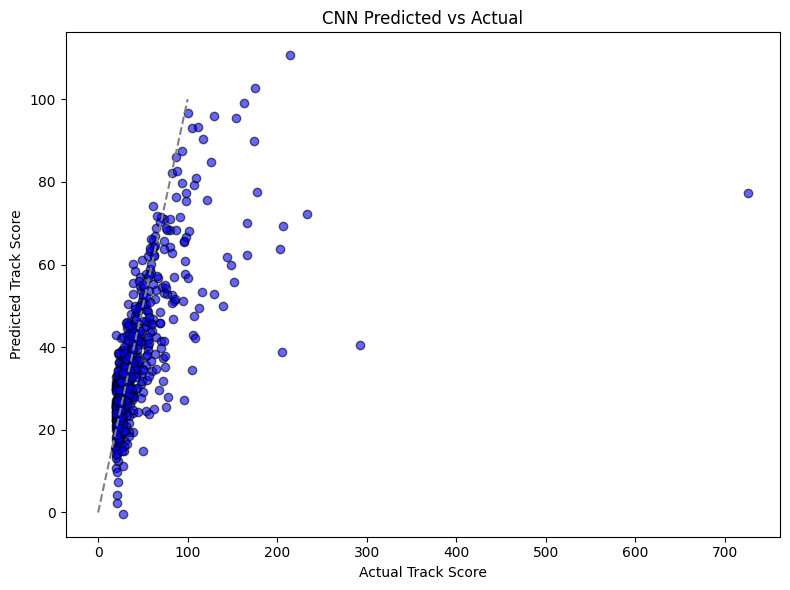


CNN Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.53      0.67       109
         Low       0.79      0.72      0.76       283
      Medium       0.57      0.75      0.65       222
         nan       0.00      0.00      0.00         0

    accuracy                           0.70       614
   macro avg       0.56      0.50      0.52       614
weighted avg       0.73      0.70      0.70       614



C:\Users\islam\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\islam\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\islam\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from sklearn.metrics import classification_report

# ==========================
# Alternative Model: Convolutional Neural Network (CNN)
# ==========================
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * (X_train.shape[1] // 2), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

cnn_model = CNNRegressor()
cnn_criterion = nn.L1Loss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

for epoch in range(500):
    cnn_model.train()
    cnn_optimizer.zero_grad()
    cnn_outputs = cnn_model(X_train)
    cnn_loss = cnn_criterion(cnn_outputs, y_train)
    cnn_loss.backward()
    cnn_optimizer.step()

cnn_model.eval()
with torch.no_grad():
    cnn_preds = cnn_model(X_test).numpy().flatten()
    y_true_cnn = y_test.numpy().flatten()
    cnn_r2 = r2_score(y_true_cnn, cnn_preds)
    cnn_mae = np.mean(np.abs(y_true_cnn - cnn_preds))
    cnn_accuracy = 100 - np.mean(np.abs((y_true_cnn - cnn_preds) / y_true_cnn) * 100)
    print(f"CNN R²: {cnn_r2:.4f}, MAE: {cnn_mae:.2f}, Accuracy: {cnn_accuracy:.2f}%")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true_cnn, cnn_preds, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
    plt.title('CNN Predicted vs Actual')
    plt.xlabel('Actual Track Score')
    plt.ylabel('Predicted Track Score')
    plt.tight_layout()
    plt.show()

    # ==========================
    # Classification Report
    # ==========================
    bins = [0, 30, 60, 750]
    labels = ['Low', 'Medium', 'High']
    y_true_class = pd.cut(y_true_cnn, bins=bins, labels=labels).astype(str)
    y_pred_class = pd.cut(cnn_preds, bins=bins, labels=labels).astype(str)

    print("\nCNN Classification Report:")
    print(classification_report(y_true_class, y_pred_class))


In [5]:
  # Export predictions
pd.DataFrame({
        'Actual Track Score': y_test.numpy().flatten(),
        'CNN Prediction': cnn_preds,
        'Random Forest Prediction': rf_preds[:len(y_test)],
        'XGBoost Prediction': xgb_preds[:len(y_test)]
    }).to_csv('model_comparisons.csv', index=False)
print("Exported predictions to 'model_comparisons.csv'")

Exported predictions to 'model_comparisons.csv'
